# Train a BNN to classify MNIST

In [1]:
# for leonhard
import os
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=" + os.environ["CUDA_HOME"]
os.environ['XLA_FLAGS']

%load_ext autoreload
# Train a Bayesian neural network to classify MNIST using
# (parallel) Langevin dynamics
#
# If using pmap, set the environment variable
# `export XLA_FLAGS="--xla_force_host_platform_device_count=8"`
# before running on CPU (this enables pmap to "see" multiple cores).
import sys
on_cluster = not os.getenv("HOME") == "/home/lauro"
if on_cluster:
    sys.path.append("/cluster/home/dlauro/projects-2020-Neural-SVGD/")
import argparse
import matplotlib.pyplot as plt
import numpy as onp
import jax.numpy as jnp

from jax import jit, value_and_grad, vmap, random, grad
from tqdm import tqdm
import optax

from nvgd.src import utils, metrics
from nvgd.experiments import dataloader, bnn
from nvgd.experiments import config as cfg

data = dataloader.data
on_cluster = not os.getenv("HOME") == "/home/lauro"

# Config
key = random.PRNGKey(0)
EPOCHS = 1
BATCH_SIZE = 128
LEARNING_RATE = 2e-7  # 1e-6 too high!!
NUM_SAMPLES = 100
DISABLE_PROGRESS_BAR = False



# initialize set of parameters
key, subkey = random.split(key)
param_set = vmap(bnn.model.init, (0, None))(
    random.split(subkey, NUM_SAMPLES), data.train_images[:5])

sgld = utils.sgld(LEARNING_RATE)
sgld_state = sgld.init(param_set)

@jit
def sgld_step(particles, grads, sgld_state):
    """Update param_set elements in parallel using Langevin dynamics."""
    g, sgld_state = sgld.update(grads, sgld_state, particles)
    particles = optax.apply_updates(particles, g)
    aux = {
        "global_grad_norm": optax.global_norm(g),
    }
    return particles, sgld_state, aux

Loading data...


# Training with parallel Langevin dynamics

In [15]:
# training loop
rundata = {}
trajectories = []
accuracies = []
step_counter = 0

# dloss = jit(vmap(value_and_grad(bnn.loss), (0, None, None)))
dloss = jit(vmap(value_and_grad(bnn.loss), (0, None, None)))

In [16]:
bnn.loss?

In [17]:
n_train_steps = 422*2
for _ in tqdm(range(n_train_steps), disable=DISABLE_PROGRESS_BAR):
    images, labels = next(data.train_batches)
    losses, grads = dloss(param_set, images, labels)
    param_set, sgld_state, aux = sgld_step(param_set, grads, sgld_state)
    aux.update({"loglikelihood": -losses.mean()})
    metrics.append_to_log(rundata, aux)
#     trajectories.append(vmap(lambda ps: jax.flatten_util.ravel_pytree(ps)[0])(param_set))

    if step_counter % 10 == 0:
        accuracies.append((step_counter, bnn.compute_acc(param_set)))
#         print(f"Step {step_counter}, Accuracy:", accuracies[-1])
    step_counter += 1

100%|██████████| 844/844 [00:24<00:00, 34.34it/s]


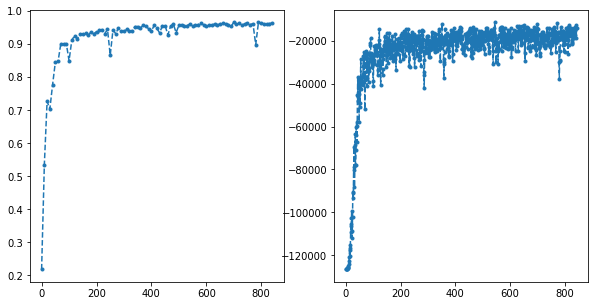

In [18]:
fig, axs = plt.subplots(1, 2, figsize=[10, 5])
axs[0].plot(*zip(*accuracies), "--.")
axs[1].plot(rundata['loglikelihood'], "--.");

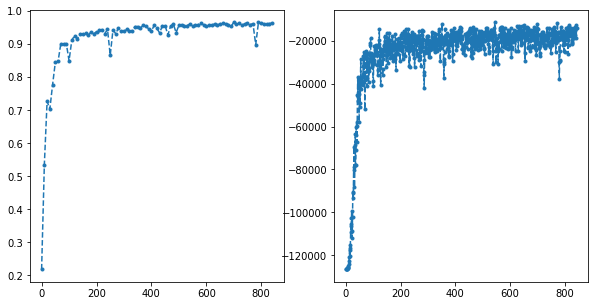

In [18]:
fig, axs = plt.subplots(1, 2, figsize=[10, 5])
axs[0].plot(*zip(*accuracies), "--.")
axs[1].plot(rundata['loglikelihood'], "--.");

In [13]:
accuracies[-1]

(840, DeviceArray(0.9671827, dtype=float32))

In [19]:
# import json_tricks as json

# savedict = {
#     "accuracy": onp.array(accuracies).tolist(),
#     "loglikelihood": onp.array(rundata['loglikelihood']).tolist(),
# }

# folder = "sgld/"
# onp.save(folder + "params.npy", vmap(bnn.ravel)(param_set))
# with open(folder + "rundata.json", "w") as f:
#     json.dump(savedict, f, indent=4)

In [21]:
plt.plot(rundata['loss']);

KeyError: 'loss'

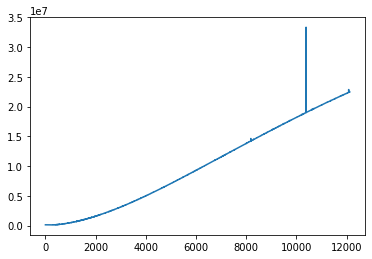

In [8]:
plt.plot(onp.array(rundata['loss']).mean(axis=1));

NameError: name 'trajectories_arr' is not defined

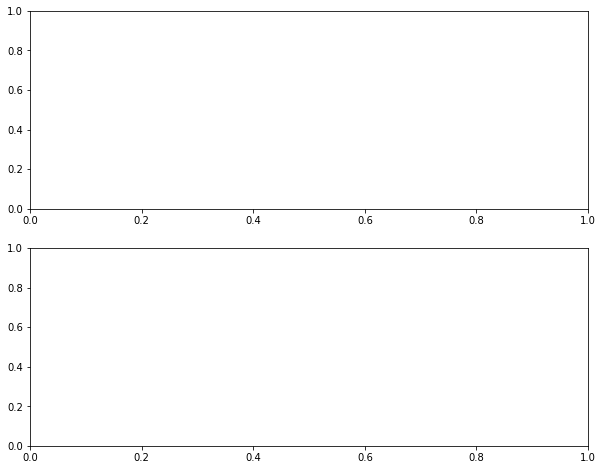

In [22]:
# visualize trajectory avg across dimensions (distinguish particles)
fig, axs = plt.subplots(2, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories_arr.mean(axis=2));  # avg across dims

ax = axs[1]
ax.plot(trajectories_arr[:, :, 0]);  # watch single param (aka single dimension)

AxisError: axis 1 is out of bounds for array of dimension 1

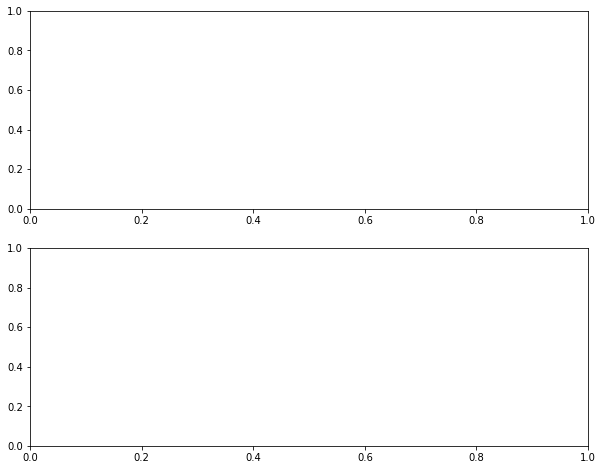

In [17]:
# visualize trajectory avg across particles (distinguish dims, ie parameters)
fig, axs = plt.subplots(2, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories_arr.mean(axis=1)); # avg across particles

ax = axs[1]
ax.plot(trajectories_arr[:, 10, :]); # watch single particle